## Simple example of TuRBO-1

In [1]:
from turbo import Turbo1
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from solair.simulation import Simulator, Simulator_Ehasan
from solair.design import Tube

## Set up an optimization problem class

In [2]:
class Csp:
    def __init__(self, dim=10):
        self.dim = dim
        self.lb = 1 * np.ones(dim)
        self.ub = 10 * np.ones(dim)
        
    def __call__(self, x):
        assert len(x) == self.dim
        assert x.ndim == 1
        assert np.all(x <= self.ub) and np.all(x >= self.lb)
        tube = Tube(tube_length=x[0])
        sim = Simulator_Ehasan(
            tube,
            verbose=0,
            n_rows=4,
            n_sub_shx=1,
            fast=False,
        )
        sim.run()
        value = sim.results["t_co2"][-1][-1] # minimize the last temperature of the last tube
        return value

f = Csp(1)

## Create a Turbo optimizer instance

In [3]:
turbo1 = Turbo1(
    f=f,  # Handle to objective function
    lb=f.lb,  # Numpy array specifying lower bounds
    ub=f.ub,  # Numpy array specifying upper bounds
    n_init=20,  # Number of initial bounds from an Latin hypercube design
    max_evals = 100,  # Maximum number of evaluations
    batch_size=10,  # How large batch size TuRBO uses
    verbose=True,  # Print information from each batch
    use_ard=True,  # Set to true if you want to use ARD for the GP kernel
    max_cholesky_size=2000,  # When we switch from Cholesky to Lanczos
    n_training_steps=50,  # Number of steps of ADAM to learn the hypers
    min_cuda=1024,  # Run on the CPU for small datasets
    device="cpu",  # "cpu" or "cuda"
    dtype="float64",  # float64 or float32
)

Using dtype = torch.float64 
Using device = cpu


# Run the optimization process

In [4]:
turbo1.optimize()

Starting from fbest = 335.9


/home/kitouni/miniconda3/envs/FDL/lib/python3.9/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1651023295661/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1666.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


30) New best: 335.9
40) New best: 335.9
50) New best: 335.9
90) Restarting with fbest = 335.9
Starting from fbest = 335.9


## Extract all evaluations from Turbo and print the best

In [7]:
X = turbo1.X  # Evaluated points
fX = turbo1.fX  # Observed values
ind_best = np.argmin(fX)
f_best, x_best = fX[ind_best], X[ind_best, :]

print("Best value found:\n\tf(x) = %.3f\nObserved at:\n\tx = %s" % (f_best, np.around(x_best, 3)))

Best value found:
	f(x) = 335.908
Observed at:
	x = [9.99]


## Plot the progress
Each trust region is independent and finds different solutions

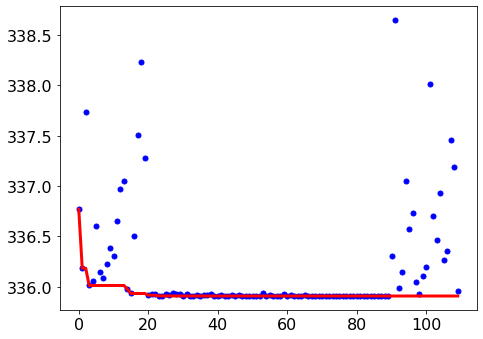

In [10]:
fig = plt.figure(figsize=(7, 5))
matplotlib.rcParams.update({'font.size': 16})
plt.plot(fX, 'b.', ms=10)  # Plot all evaluated points as blue dots
plt.plot(np.minimum.accumulate(fX), 'r', lw=3)  # Plot cumulative minimum as a red line
# plt.xlim([0, len(fX)])
# plt.ylim([0, 30])

plt.tight_layout()
plt.show()